In [62]:
#import necessary library

import pandas as pd
import numpy as np
import random as rnd     

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

from sklearn.preprocessing import StandardScaler
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,KNNImputer
from sklearn.pipeline import FeatureUnion,make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')


This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.

In [63]:
#read the dataset through head method

data = pd.read_csv(r'https://raw.githubusercontent.com/dsrscientist/Dataset2/main/temperature.csv')
data.head()


,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,30-06-2013,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,30-06-2013,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,30-06-2013,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,30-06-2013,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,30-06-2013,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [64]:
data.columns


Index(['station', 'Date', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin',
       'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS',
       'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4',
       'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon',
       'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin'],
      dtype='object')

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


In [66]:
data.shape

(7752, 25)

In [67]:
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_columns


Index(['Date'], dtype='object')

In [68]:
#we can drop date column as it is unlikely to contribute directly to the temperature predictions. 
data.drop(['Date'],axis=1,inplace=True)


In [69]:
numerical_column = data.select_dtypes(include=['float64']).columns
numerical_column

Index(['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope',
       'Solar radiation', 'Next_Tmax', 'Next_Tmin'],
      dtype='object')

In [70]:
data.shape

(7752, 24)

In [71]:
data.head()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [72]:
data.isna().sum()

station              2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64

In [73]:
#imputing the null values using imputer

imp = SimpleImputer(strategy='mean')
data['station'] = imp.fit_transform(data['station'].values.reshape(-1, 1) )
data['Present_Tmax'] = imp.fit_transform(data['Present_Tmax'].values.reshape(-1, 1) )
data['Present_Tmin'] = imp.fit_transform(data['Present_Tmin'].values.reshape(-1, 1) )
data['LDAPS_RHmin'] = imp.fit_transform(data['LDAPS_RHmin'].values.reshape(-1, 1) )
data['LDAPS_RHmax'] = imp.fit_transform(data['LDAPS_RHmax'].values.reshape(-1, 1) )
data['LDAPS_Tmax_lapse'] = imp.fit_transform(data['LDAPS_Tmax_lapse'].values.reshape(-1, 1) )
data['LDAPS_Tmin_lapse'] = imp.fit_transform(data['LDAPS_Tmin_lapse'].values.reshape(-1, 1) )
data['LDAPS_WS'] = imp.fit_transform(data['LDAPS_WS'].values.reshape(-1, 1) )
data['LDAPS_LH'] = imp.fit_transform(data['LDAPS_LH'].values.reshape(-1, 1) )
data['LDAPS_CC1'] = imp.fit_transform(data['LDAPS_CC1'].values.reshape(-1, 1) )
data['LDAPS_CC2'] = imp.fit_transform(data['LDAPS_CC2'].values.reshape(-1, 1) )
data['LDAPS_CC3'] = imp.fit_transform(data['LDAPS_CC3'].values.reshape(-1, 1) )
data['LDAPS_CC4'] = imp.fit_transform(data['LDAPS_CC4'].values.reshape(-1, 1) )
data['LDAPS_PPT1'] = imp.fit_transform(data['LDAPS_PPT1'].values.reshape(-1, 1) )
data['LDAPS_PPT2'] = imp.fit_transform(data['LDAPS_PPT2'].values.reshape(-1, 1) )
data['LDAPS_PPT3'] = imp.fit_transform(data['LDAPS_PPT3'].values.reshape(-1, 1) )
data['LDAPS_PPT4'] = imp.fit_transform(data['LDAPS_PPT4'].values.reshape(-1, 1) )
data['Next_Tmax'] = imp.fit_transform(data['Next_Tmax'].values.reshape(-1, 1) )
data['Next_Tmin'] = imp.fit_transform(data['Next_Tmin'].values.reshape(-1, 1) )





In [74]:
data.isna().sum()  #we have treated all the nulls

station             0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64

In [75]:
data.describe()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
count,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,...,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000
mean,13.000000,29.768211,23.225059,56.759372,88.374804,29.613447,23.512589,7.097875,62.505019,0.368774,...,0.485003,0.278200,0.269407,37.544722,126.991397,61.867972,1.257048,5341.502803,30.274887,22.932220
std,7.210637,2.956557,2.403036,14.596973,7.157124,2.932898,2.333973,2.173245,33.567001,0.261185,...,1.754258,1.156174,1.200364,0.050352,0.079435,54.279780,1.370444,429.158867,3.122557,2.483276
min,1.000000,20.000000,11.300000,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,...,0.000000,0.000000,0.000000,37.456200,126.826000,12.370000,0.098475,4329.520508,17.400000,11.300000
25%,7.000000,27.800000,21.700000,46.046162,84.316923,27.693091,22.114651,5.686487,37.532764,0.148321,...,0.000000,0.000000,0.000000,37.510200,126.937000,28.700000,0.271300,4999.018555,28.200000,21.400000
50%,13.000000,29.900000,23.400000,55.313244,89.699505,29.662273,23.735942,6.563068,57.310630,0.320110,...,0.000000,0.000000,0.000000,37.550700,126.995000,45.716000,0.618000,5436.345215,30.500000,23.100000
75%,19.000000,32.000000,24.900000,67.038254,93.704500,31.683819,25.134000,8.007471,83.904586,0.571696,...,0.024276,0.009697,0.000693,37.577600,127.042000,59.832400,1.767800,5728.316406,32.600000,24.600000
max,25.000000,37.600000,29.900000,98.524734,100.000153,38.542255,29.619342,21.857621,213.414006,0.967277,...,21.621661,15.841235,16.655469,37.645000,127.135000,212.335000,5.178230,5992.895996,38.900000,29.800000


In [76]:
cor = data.corr()
cor


,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
station,1.000000,0.112655,0.131646,-0.066733,-0.166984,0.069107,0.104758,0.005277,-0.133357,0.006919,...,-0.008250,-0.012461,-0.010401,-0.237502,-0.118704,-0.255830,-0.090061,-0.019001,0.107983,0.128293
Present_Tmax,0.112655,1.000000,0.618760,-0.204571,-0.301787,0.570129,0.623496,-0.121820,0.135463,-0.311805,...,-0.099449,-0.120367,-0.099607,-0.052615,0.009020,-0.187121,-0.105809,-0.025439,0.610348,0.622741
Present_Tmin,0.131646,0.618760,1.000000,0.123143,-0.015140,0.464151,0.762993,-0.034675,-0.009258,0.084447,...,0.068176,-0.046126,-0.062965,-0.078475,-0.043461,-0.250275,-0.146339,0.053578,0.471806,0.796670
LDAPS_RHmin,-0.066733,-0.204571,0.123143,1.000000,0.579141,-0.564580,0.089476,0.294361,-0.070858,0.613818,...,0.390967,0.240642,0.168595,0.087099,-0.076237,0.102115,0.123744,0.244080,-0.437898,0.095019
LDAPS_RHmax,-0.166984,-0.301787,-0.015140,0.579141,1.000000,-0.373404,-0.114143,0.135333,0.238579,0.436652,...,0.229050,0.134607,0.117853,0.195798,0.025667,0.177168,0.219599,0.149261,-0.283738,-0.071997
LDAPS_Tmax_lapse,0.069107,0.570129,0.464151,-0.564580,-0.373404,1.000000,0.654021,-0.311996,0.048010,-0.438439,...,-0.242122,-0.188115,-0.160273,-0.042093,0.090666,-0.178895,-0.162332,0.047971,0.827189,0.586868
LDAPS_Tmin_lapse,0.104758,0.623496,0.762993,0.089476,-0.114143,0.654021,1.000000,-0.130035,-0.134761,0.010901,...,0.000870,-0.088575,-0.094655,-0.096257,-0.026701,-0.195455,-0.185849,0.159975,0.586983,0.880176
LDAPS_WS,0.005277,-0.121820,-0.034675,0.294361,0.135333,-0.311996,-0.130035,1.000000,0.006711,0.289445,...,0.191886,0.161684,0.144085,0.036657,-0.059466,0.191053,0.171629,0.121759,-0.342729,-0.096576
LDAPS_LH,-0.133357,0.135463,-0.009258,-0.070858,0.238579,0.048010,-0.134761,0.006711,1.000000,-0.147296,...,-0.077545,0.016102,0.019979,0.133221,0.025822,0.055133,0.086781,-0.047384,0.157616,-0.055440
LDAPS_CC1,0.006919,-0.311805,0.084447,0.613818,0.436652,-0.438439,0.010901,0.289445,-0.147296,1.000000,...,0.389453,0.168742,0.091722,-0.008131,-0.006843,-0.014090,-0.020752,0.218309,-0.452541,-0.011028


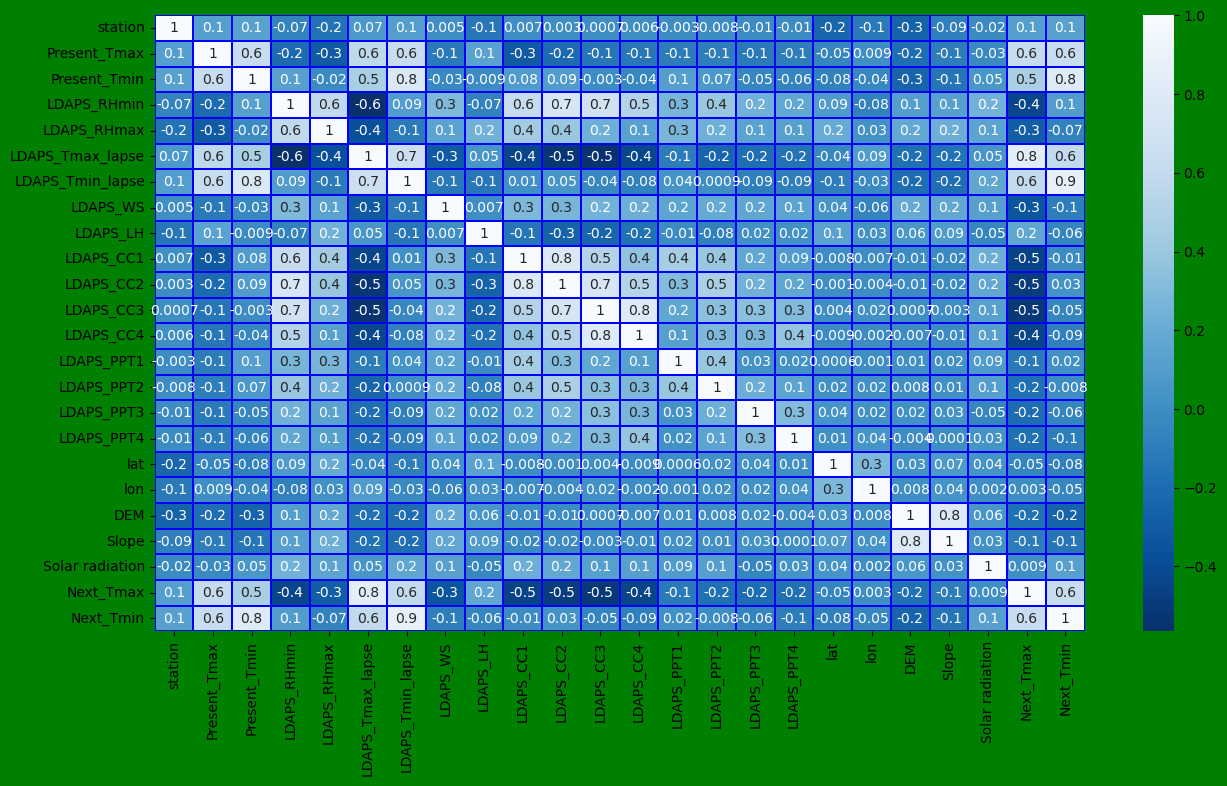

In [77]:
#we will use heatmap to check the multicollinearity
plt.figure(figsize=(15,8), facecolor='green')
sns.heatmap(data.corr(), linewidths = 0.1, fmt = '.1g', linecolor = 'b', annot = True, cmap = 'Blues_r')
plt.yticks(rotation = 0);
plt.show()

there is no as such multicollinearity issue found from the above heatmap

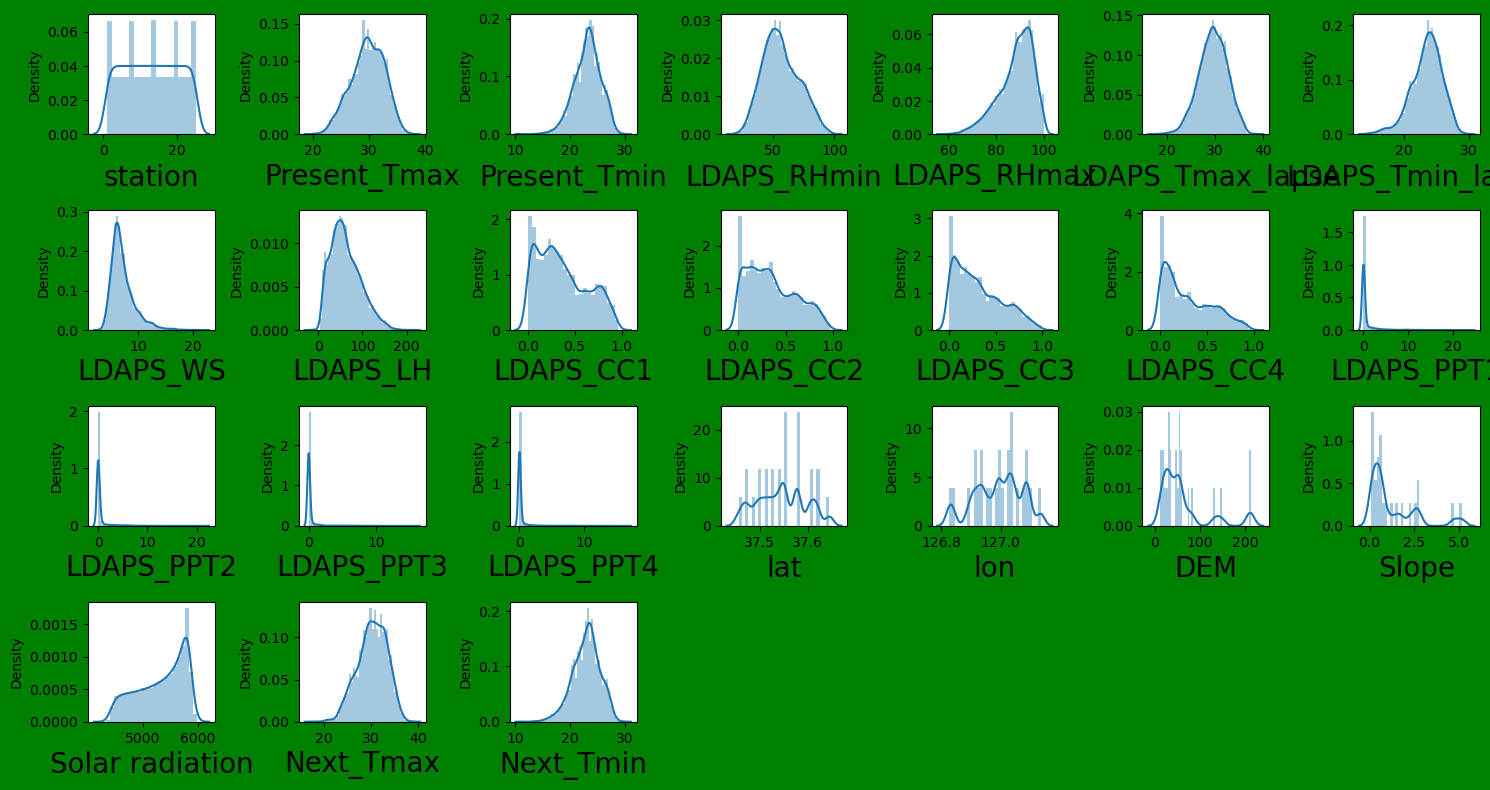

In [78]:
plt.figure(figsize=(15,8), facecolor='green')
plotnumber = 1

for column in data:
    if plotnumber<=25:
        ax = plt.subplot(4,7,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize=20)
        
    plotnumber+=1
plt.tight_layout()

In [79]:
data.skew() # there is skewness found in the data so we will try to remove it

station             0.000000
Present_Tmax       -0.264137
Present_Tmin       -0.367538
LDAPS_RHmin         0.300220
LDAPS_RHmax        -0.855015
LDAPS_Tmax_lapse   -0.227880
LDAPS_Tmin_lapse   -0.581763
LDAPS_WS            1.579236
LDAPS_LH            0.673757
LDAPS_CC1           0.459458
LDAPS_CC2           0.472350
LDAPS_CC3           0.640735
LDAPS_CC4           0.666482
LDAPS_PPT1          5.393821
LDAPS_PPT2          5.775355
LDAPS_PPT3          6.457129
LDAPS_PPT4          6.825464
lat                 0.087062
lon                -0.285213
DEM                 1.723257
Slope               1.563020
Solar radiation    -0.511210
Next_Tmax          -0.340200
Next_Tmin          -0.404447
dtype: float64

In [80]:
#we will reduce the skewness through cube root method

data['LDAPS_WS']=np.cbrt(data['LDAPS_WS'])
data['LDAPS_PPT1']=np.cbrt(data['LDAPS_PPT1'])
data['LDAPS_PPT2']=np.cbrt(data['LDAPS_PPT2'])
data['LDAPS_PPT3']=np.cbrt(data['LDAPS_PPT3'])
data['LDAPS_PPT4']=np.cbrt(data['LDAPS_PPT4'])
data['Slope']=np.cbrt(data['Slope'])
data['DEM']=np.cbrt(data['DEM'])


In [81]:
data.skew() #as we can see we have successfully reduced the skewness

station             0.000000
Present_Tmax       -0.264137
Present_Tmin       -0.367538
LDAPS_RHmin         0.300220
LDAPS_RHmax        -0.855015
LDAPS_Tmax_lapse   -0.227880
LDAPS_Tmin_lapse   -0.581763
LDAPS_WS            0.884657
LDAPS_LH            0.673757
LDAPS_CC1           0.459458
LDAPS_CC2           0.472350
LDAPS_CC3           0.640735
LDAPS_CC4           0.666482
LDAPS_PPT1          1.922841
LDAPS_PPT2          2.223126
LDAPS_PPT3          2.523911
LDAPS_PPT4          2.792122
lat                 0.087062
lon                -0.285213
DEM                 0.919779
Slope               0.614110
Solar radiation    -0.511210
Next_Tmax          -0.340200
Next_Tmin          -0.404447
dtype: float64

In [82]:
#split the data into features and target variable
y_max = data['Next_Tmax']
X = data.drop(['Next_Tmax', 'Next_Tmin'], axis=1)
y_min = data['Next_Tmin']


In [83]:
#scaling the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [86]:
#splitting the data into training and testing so that we could make predictions further

X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X,y_max, test_size = 0.30, random_state = 300)
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X,y_min, test_size = 0.30, random_state = 300)


In [87]:
regression_max = LinearRegression()
regression_max.fit(X_train_max, y_train_max)


LinearRegression()

In [88]:
regression_max.score(X_train_max,y_train_max) #here is the score of train data

0.765256643132967

In [89]:
regression_max.score(X_test_max,y_test_max) #here is the score of test data

0.761079200031969

In [90]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.linear_model import Lasso,Ridge
from sklearn.model_selection import cross_val_score


In [91]:
pred_LR_max = regression_max.predict(X_test_max)
pred_train_max=regression_max.predict(X_train_max)
print("r2_score:" , r2_score(y_test_max,pred_LR_max))
print("r2_score on training data:" ,r2_score(y_train_max,pred_train_max)*100 )
print("Mean absolute error:" ,mean_absolute_error(y_test_max, pred_LR_max))
print("Mean squared erroe:" ,mean_squared_error(y_test_max, pred_LR_max))
print("Root mean squared error:" ,np.sqrt(mean_squared_error(y_test_max, pred_LR_max)))


r2_score: 0.761079200031969
r2_score on training data: 76.5256643132967
Mean absolute error: 1.1611534459030406
Mean squared erroe: 2.3211447550990356
Root mean squared error: 1.5235303590998885


In [92]:
RFR_MAX = RandomForestRegressor()
RFR_MAX.fit(X_train_max, y_train_max)


RandomForestRegressor()

In [93]:
RFR_MAX.score(X_train_max,y_train_max) #here is the score of train data

0.9852086104405454

In [94]:
RFR_MAX.score(X_test_max,y_test_max) #here is the score of test data

0.8899528445408031

In [95]:
pred_RFR_max = RFR_MAX.predict(X_test_max)
pred_train_max=RFR_MAX.predict(X_train_max)
print("Mean absolute error:" ,mean_absolute_error(y_test_max, pred_RFR_max))
print("Mean squared error:" ,mean_squared_error(y_test_max, pred_RFR_max))


Mean absolute error: 0.7429588284400067
Mean squared error: 1.0691215571932695


In [96]:
import joblib
joblib.dump(RFR_MAX, 'Temp_Forecast.pkl')


['Temp_Forecast.pkl']

In [97]:
Model = joblib.load('Temp_Forecast.pkl')

prediction_max = RFR_MAX.predict(X_test_max)  
prediction


array([33.048     , 23.597     , 35.159     , ..., 31.71649773,
       32.514     , 32.009     ])

here is the predicted and the actual value for Next_Tmax

In [98]:
a = np.array(y_test_max)
data = pd.DataFrame()
data['Predicted']=prediction_max
data['Actual']=a
data


,Predicted,Actual
0,32.941000,32.5
1,23.421000,24.6
2,35.231000,36.1
3,30.762744,30.9
4,32.381000,32.7
...,...,...
2321,32.702000,32.7
2322,31.936000,31.7
2323,31.819749,32.1
2324,32.237498,33.9


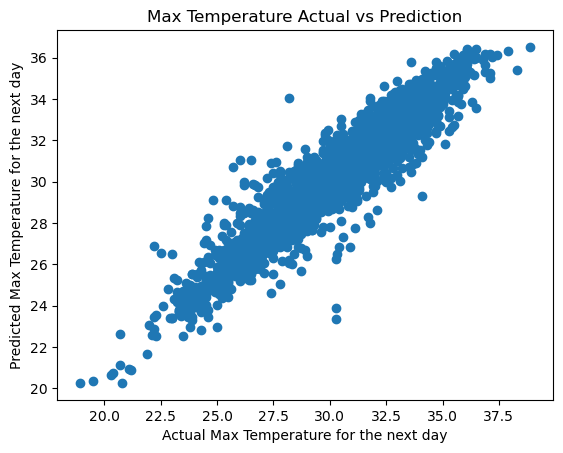

In [99]:
plt.scatter(y_test_max, prediction_max)
plt.xlabel('Actual Max Temperature for the next day')
plt.ylabel('Predicted Max Temperature for the next day')
plt.title('Max Temperature Actual vs Prediction')
plt.show()

Now we will predict for Next_Tmin

In [100]:
#training the model for next day min temp
regression_min = LinearRegression()
regression_min.fit(X_train_min, y_train_min)


LinearRegression()

In [101]:
regression_min.score(X_train_min,y_train_min) #here is the score of train data

0.8284080584287241

In [102]:
regression_min.score(X_test_min,y_test_min) #here is the score of test data

0.8292537614057464

In [103]:
pred_LR_min = regression_min.predict(X_test_min)
pred_train_min=regression_min.predict(X_train_min)
print("r2_score:" , r2_score(y_test_min,pred_LR_min))
print("r2_score on training data:" ,r2_score(y_train_min,pred_train_min)*100 )
print("Mean absolute error:" ,mean_absolute_error(y_test_min, pred_LR_min))
print("Mean squared erroe:" ,mean_squared_error(y_test_min, pred_LR_min))
print("Root mean squared error:" ,np.sqrt(mean_squared_error(y_test_min, pred_LR_min)))


r2_score: 0.8292537614057464
r2_score on training data: 82.84080584287241
Mean absolute error: 0.7857362047364713
Mean squared erroe: 1.0346479738402745
Root mean squared error: 1.017176471336353


In [104]:
RFR_MIN = RandomForestRegressor()
RFR_MIN.fit(X_train_min, y_train_min)


RandomForestRegressor()

In [105]:
RFR_MIN.score(X_train_min,y_train_min) #here is the score of train data

0.9854631176974454

In [106]:
RFR_MIN.score(X_test_min,y_test_min) #here is the score of test data

0.9015104266204249

In [107]:
pred_RFR_min = RFR_MIN.predict(X_test_min)
pred_train_min=RFR_MIN.predict(X_train_min)
print("Mean absolute error:" ,mean_absolute_error(y_test_min, pred_RFR_min))
print("Mean squared error:" ,mean_squared_error(y_test_min, pred_RFR_min))


Mean absolute error: 0.5787612248759625
Mean squared error: 0.5968039962726291


In [108]:
Model = joblib.load('Temp_Forecast.pkl')

prediction_min = RFR_MIN.predict(X_test_min)  
prediction


array([33.048     , 23.597     , 35.159     , ..., 31.71649773,
       32.514     , 32.009     ])

here is the predicted and the actual value for Next_Tmax

In [109]:
a = np.array(y_test_min)
data = pd.DataFrame()
data['Predicted']=prediction_min
data['Actual']=a
data


,Predicted,Actual
0,27.043000,27.5
1,15.826000,15.7
2,26.419000,26.3
3,24.223967,24.4
4,25.369322,24.9
...,...,...
2321,23.454000,23.6
2322,25.298644,26.2
2323,25.480000,25.2
2324,25.373322,26.2


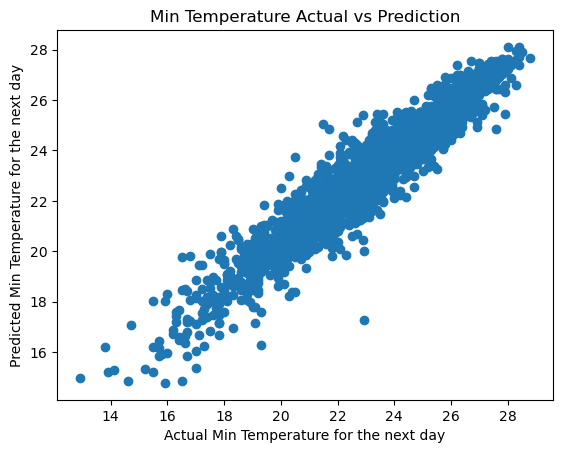

In [110]:
plt.scatter(y_test_min, prediction_min)
plt.xlabel('Actual Min Temperature for the next day')
plt.ylabel('Predicted Min Temperature for the next day')
plt.title('Min Temperature Actual vs Prediction')
plt.show() 